# Car Part Detection

Problem: Non-car savy people can easily get scammed by garages when they cannot identify the part that is causing the problem. 

Creating an application that can identify a part for a car owner allows them to research more into the part and what may be causing an issue.

In [55]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# CHECKING IF GOOGLE COLAB ENVIRONMENT OR LOCAL

GOOGLE_COLAB = False
DATASET_ROOT = 'datasets/car_part/'

try:
    import google_colab
    GOOGLE_COLAB = True
    DATASET_ROOT = '/content/car_part/'
except ImportError:
    GOOGLE_COLAB = False
    DATASET_ROOT = 'datasets/car_part/'

## Loading Data

In [211]:
df = pd.read_csv(DATASET_ROOT + "train_car.csv")
df

,class index,filepaths,labels,data set
0,0,train/AIR COMPRESSOR/001.jpg,AIR COMPRESSOR,train
1,0,train/AIR COMPRESSOR/002.jpg,AIR COMPRESSOR,train
2,0,train/AIR COMPRESSOR/003.jpg,AIR COMPRESSOR,train
3,0,train/AIR COMPRESSOR/004.jpg,AIR COMPRESSOR,train
4,0,train/AIR COMPRESSOR/005.jpg,AIR COMPRESSOR,train
...,...,...,...,...
8734,49,train/WINDOW REGULATOR/175.jpg,WINDOW REGULATOR,train
8735,49,train/WINDOW REGULATOR/176.jpg,WINDOW REGULATOR,train
8736,49,train/WINDOW REGULATOR/177.jpg,WINDOW REGULATOR,train
8737,49,train/WINDOW REGULATOR/178.jpg,WINDOW REGULATOR,train


In [212]:
# add DATASET_ROOT + /car_part/ to filepaths
df['filepaths'] = df['filepaths'].apply(lambda path: DATASET_ROOT + path)
df

,class index,filepaths,labels,data set
0,0,datasets/car_part/train/AIR COMPRESSOR/001.jpg,AIR COMPRESSOR,train
1,0,datasets/car_part/train/AIR COMPRESSOR/002.jpg,AIR COMPRESSOR,train
2,0,datasets/car_part/train/AIR COMPRESSOR/003.jpg,AIR COMPRESSOR,train
3,0,datasets/car_part/train/AIR COMPRESSOR/004.jpg,AIR COMPRESSOR,train
4,0,datasets/car_part/train/AIR COMPRESSOR/005.jpg,AIR COMPRESSOR,train
...,...,...,...,...
8734,49,datasets/car_part/train/WINDOW REGULATOR/175.jpg,WINDOW REGULATOR,train
8735,49,datasets/car_part/train/WINDOW REGULATOR/176.jpg,WINDOW REGULATOR,train
8736,49,datasets/car_part/train/WINDOW REGULATOR/177.jpg,WINDOW REGULATOR,train
8737,49,datasets/car_part/train/WINDOW REGULATOR/178.jpg,WINDOW REGULATOR,train


## EDA

### Class Balance

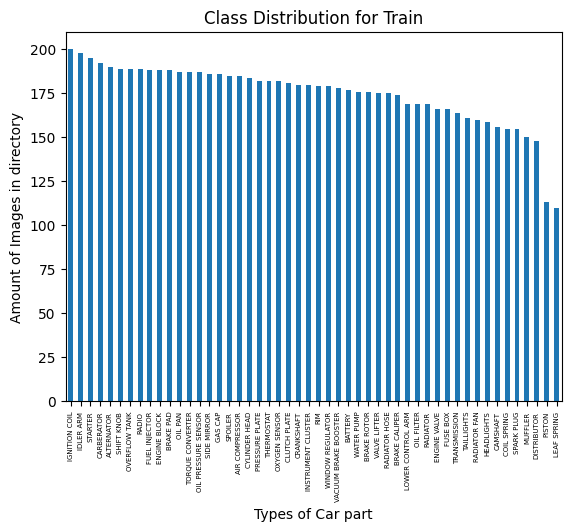

In [213]:
df['labels'].value_counts().plot(kind="bar")

plt.tick_params(axis='x', which='major', labelsize=5)
plt.xlabel("Types of Car part")
plt.ylabel("Amount of Images in directory")
plt.title("Class Distribution for Train")

plt.show()

This shows a somewhat even distribution between classes is somewhat even. There might be some bias towards the classes with the highest images 

### Image Size

In [10]:
from PIL import Image
from tqdm import tqdm

In [11]:
def get_dim(file):
    """
        Returns the image height & width
    """
    img = Image.open(file)
    arr = np.array(img)
    dims = arr.shape
    return (dims[0], dims[1])

In [12]:
# create new df for plotting image dimensions
filepaths = df['filepaths']

dims = []
for path in tqdm(filepaths):
    dims.append(get_dim(path))

100%|██████████| 8739/8739 [00:09<00:00, 940.76it/s] 


In [13]:
res_df = pd.DataFrame(dims, columns=['height', 'width'])
res_df

,height,width
0,224,224
1,224,224
2,224,224
3,224,224
4,224,224
...,...,...
8734,224,224
8735,224,224
8736,224,224
8737,224,224


Text(0.5, 1.0, 'Image Resolution')

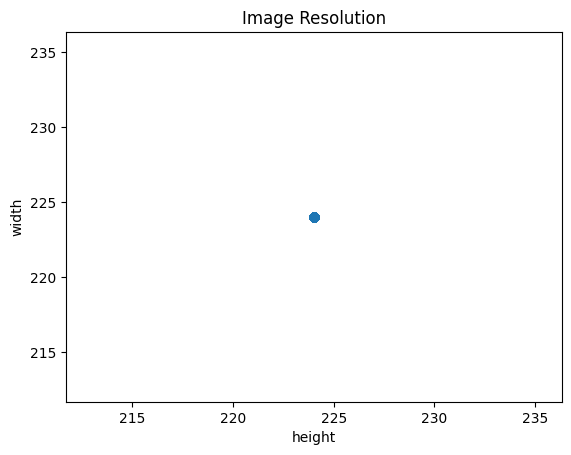

In [14]:
# plot into scatter plot
fig, axes = plt.subplots()

axes.scatter(x=res_df['width'], y=res_df['height'])
axes.set_xlabel("height")
axes.set_ylabel("width")

axes.set_title("Image Resolution")

All images are uniform resolution. No resizing needed

### Image Sampling

In [170]:
import random
import cv2

In [192]:
# generate 4 random image index
img_inds = []
for i in range(0,5):
    img_inds.append(random.randint(0, len(df)))

img_inds

[4449, 860, 5133, 6439, 7622]

(-0.5, 223.5, 223.5, -0.5)

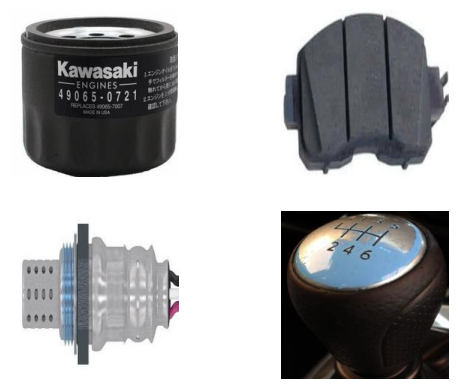

In [193]:
fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(cv2.imread(df.loc[img_inds[0]]['filepaths']))
axes[0, 1].imshow(cv2.imread(df.loc[img_inds[1]]['filepaths']))
axes[1, 0].imshow(cv2.imread(df.loc[img_inds[2]]['filepaths']))
axes[1, 1].imshow(cv2.imread(df.loc[img_inds[3]]['filepaths']))

axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')

## Attempt 1: No Processing

### Building model

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [16]:
def build_model():
    base_model = InceptionV3(input_shape = (224, 224, 3), # image shape
                             include_top = False, # exclude the output layer of the model
                             weights='imagenet'
                            )
    
    base_model.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [274]:
model = build_model()

In [273]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_658 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_658[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_658      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_659 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_658[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_659[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_659      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_660 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_659[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_660[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_660      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 54, 54,    │          0 │ activation_660[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_661 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_28… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_661[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_661      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_662 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_661[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_662[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_662      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 179,246,008 (683.77 MB)

 Trainable params: 52,481,074 (200.20 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 104,962,150 (400.40 MB)

In [240]:
# # callback function to stop training when target acc reached
# class myCallbacK(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, log={}):
#         if log.get('accuracy'):
#             if log.get('accuracy') > 0.955:
#                 self.model.stop_training = True

### Generating Datasets

This does not contain any image augmentation.

In [235]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [236]:
# Without any augmentation
image_size = (224, 224)
batch_size = 32

# Training Set
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

train_ds = train_gen.flow_from_directory(
    DATASET_ROOT + 'train',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation Set
validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = validation_gen.flow_from_directory(
    DATASET_ROOT + 'valid',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8739 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


### Training Model

In [237]:
model = build_model()

In [241]:
history = model.fit(
    train_ds, 
    epochs=20, 
    validation_data=val_ds, 
    callbacks=myCallbacK()
)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 235s 858ms/step - accuracy: 0.7642 - loss: 0.8472 - val_accuracy: 0.8000 - val_loss: 0.7809
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 232s 847ms/step - accuracy: 0.8321 - loss: 0.5661 - val_accuracy: 0.7400 - val_loss: 1.1639
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 232s 845ms/step - accuracy: 0.8502 - loss: 0.4944 - val_accuracy: 0.8360 - val_loss: 0.8659
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 233s 849ms/step - accuracy: 0.8859 - loss: 0.3721 - val_accuracy: 0.8120 - val_loss: 0.7981
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 221s 805ms/step - accuracy: 0.8907 - loss: 0.3585 - val_accuracy: 0.7920 - val_loss: 0.8649
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 220s 803ms/step - accuracy: 0.9071 - loss: 0.2996 - val_accuracy: 0.8200 - val_loss: 0.9133
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 222s 809ms/step - accuracy: 0.9115 - loss: 0.2788 - val_accuracy: 0.8040 - val_loss: 0.9661
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 219s 800ms/step - accuracy: 0.8995 -

In [242]:
model.save("models/model.h5")

### Model Evaluation

In [248]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.763588,0.839265,0.800,0.780915,0
1,0.820918,0.613892,0.740,1.163917,1
2,0.859824,0.459183,0.836,0.865915,2
3,0.883511,0.382846,0.812,0.798078,3
4,0.897128,0.340089,0.792,0.864919,4
5,0.907312,0.307810,0.820,0.913320,5
6,0.906397,0.304270,0.804,0.966111,6
7,0.887401,0.398714,0.832,1.147498,7
8,0.877331,0.461974,0.780,1.123178,8
9,0.892093,0.401479,0.792,1.307345,9


In [ ]:
import matplotlib.pyplot as plt

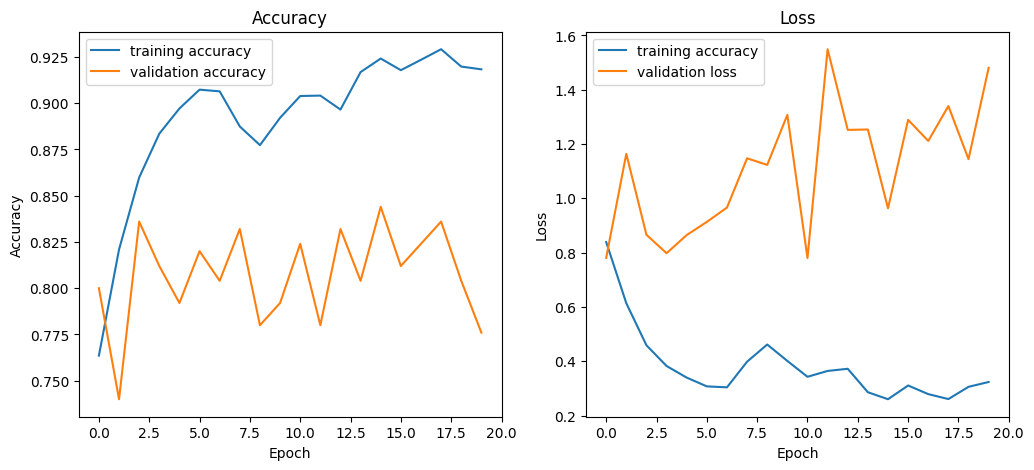

In [272]:
# accuracy plot
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axes[0].plot(hist['epoch'], hist['accuracy'], label='training accuracy')
axes[0].plot(hist['epoch'], hist['val_accuracy'], label='validation accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlim(-1, 20)
axes[0].legend()

axes[1].plot(hist['epoch'], hist['loss'], label='training accuracy')
axes[1].plot(hist['epoch'], hist['val_loss'], label='validation loss')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].set_xlim(-1, 20)
axes[1].legend()

plt.show()

In [244]:
# Retrieve the history of the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Retrieve the last entry in the training and validation accuracy lists
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")


Final Training Accuracy: 91.83%
Final Validation Accuracy: 77.60%


In [ ]:
# This approach has lead to overfitting.

The attempt lead to overfitting. The cause for it is unknown. 

It could be due to too much data, complex model architecture or other things.

## Attempt 2: Data Split & Class Reduction

### Building Model

In [214]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [215]:
def build_model(output_classes=50):
    base_model = InceptionV3(input_shape = (224, 224, 3), # image shape
                             include_top = False, # exclude the output layer of the model
                             weights='imagenet'
                            )
    
    base_model.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(output_classes, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [95]:
# callback function to stop training when target acc reached
class myCallbacK(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if log.get('acc'):
            if log.get('acc') > 0.955:
                self.model.stop_training = True

### Generating Datasets

In [216]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split

In [217]:
image_size = (224, 224)
batch_size=32

# selecting only the top 10 classes
top_10 = [
    "IGNITION COIL",
    "IDLER ARM",
    "STARTER",
    "CARBERATOR",
    "ALTERNATOR",
    "SHIFT KNOB",
    "OVERFLOW TANK",
    "RADIO",
    "FUEL INJECTOR",
    "ENGINE BLOCK"
]

In [218]:
# filter df to only include the top 10 classes

filtered_df = df[df['labels'].isin(top_10)]
filtered_df

,class index,filepaths,labels,data set
185,1,datasets/car_part/train/ALTERNATOR/001.jpg,ALTERNATOR,train
186,1,datasets/car_part/train/ALTERNATOR/002.jpg,ALTERNATOR,train
187,1,datasets/car_part/train/ALTERNATOR/003.jpg,ALTERNATOR,train
188,1,datasets/car_part/train/ALTERNATOR/004.jpg,ALTERNATOR,train
189,1,datasets/car_part/train/ALTERNATOR/005.jpg,ALTERNATOR,train
...,...,...,...,...
7332,41,datasets/car_part/train/STARTER/191.jpg,STARTER,train
7333,41,datasets/car_part/train/STARTER/192.jpg,STARTER,train
7334,41,datasets/car_part/train/STARTER/193.jpg,STARTER,train
7335,41,datasets/car_part/train/STARTER/194.jpg,STARTER,train


In [219]:
# split dataframe into 70/30 for train&val/test
train_val_df, test_df = train_test_split(
    filtered_df, test_size=0.3, random_state=1
)

In [220]:
# split train%val into 70:30 for train/val
train_df, val_df = train_test_split(
    train_val_df, test_size=0.3, random_state=1
)
train_df

,class index,filepaths,labels,data set
5048,28,datasets/car_part/train/OVERFLOW TANK/160.jpg,OVERFLOW TANK,train
4912,28,datasets/car_part/train/OVERFLOW TANK/024.jpg,OVERFLOW TANK,train
6427,37,datasets/car_part/train/SHIFT KNOB/001.jpg,SHIFT KNOB,train
338,1,datasets/car_part/train/ALTERNATOR/154.jpg,ALTERNATOR,train
347,1,datasets/car_part/train/ALTERNATOR/163.jpg,ALTERNATOR,train
...,...,...,...,...
6231,35,datasets/car_part/train/RADIO/173.jpg,RADIO,train
2301,13,datasets/car_part/train/ENGINE BLOCK/016.jpg,ENGINE BLOCK,train
240,1,datasets/car_part/train/ALTERNATOR/056.jpg,ALTERNATOR,train
6127,35,datasets/car_part/train/RADIO/069.jpg,RADIO,train


In [221]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

# convert dataframes into datasets
train_ds = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1
)

val_ds = train_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1
)

test_ds = train_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1,
    shuffle=False
)

Found 939 validated image filenames belonging to 10 classes.


Found 403 validated image filenames belonging to 10 classes.
Found 576 validated image filenames belonging to 10 classes.


### Training Model

In [222]:
model = build_model(output_classes=10)

In [223]:
history = model.fit(
    train_ds, 
    epochs=20, 
    validation_data=val_ds, 
    callbacks=myCallbacK()
)

Epoch 1/20


f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3191 - loss: 55.9240 - val_accuracy: 0.8437 - val_loss: 2.1974
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8782 - loss: 1.8523 - val_accuracy: 0.8412 - val_loss: 1.6070
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9422 - loss: 0.4383 - val_accuracy: 0.9057 - val_loss: 0.9303
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9780 - loss: 0.1498 - val_accuracy: 0.8834 - val_loss: 1.1968
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9847 - loss: 0.0910 - val_accuracy: 0.9181 - val_loss: 0.5020
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9847 - loss: 0.0665 - val_accuracy: 0.9082 - val_loss: 0.7896
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9851 - loss: 0.0891 - val_accuracy: 0.9082 - val_loss: 0.6962
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9879 - loss: 0.0497 - val_accuracy: 0.9355 - val_loss: 0.5811
Ep

### Model Evaluation

In [224]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.496273,34.280647,0.843672,2.197405,0
1,0.888179,1.495264,0.841191,1.606970,1
2,0.951012,0.365307,0.905707,0.930297,2
3,0.976571,0.184201,0.883375,1.196841,3
4,0.984026,0.089864,0.918114,0.502036,4
5,0.984026,0.071077,0.908189,0.789550,5
6,0.986156,0.090950,0.908189,0.696216,6
7,0.988285,0.052456,0.935484,0.581140,7
8,1.000000,0.001369,0.930521,0.525499,8
9,0.996805,0.005745,0.915633,0.754404,9


In [225]:
import matplotlib.pyplot as plt

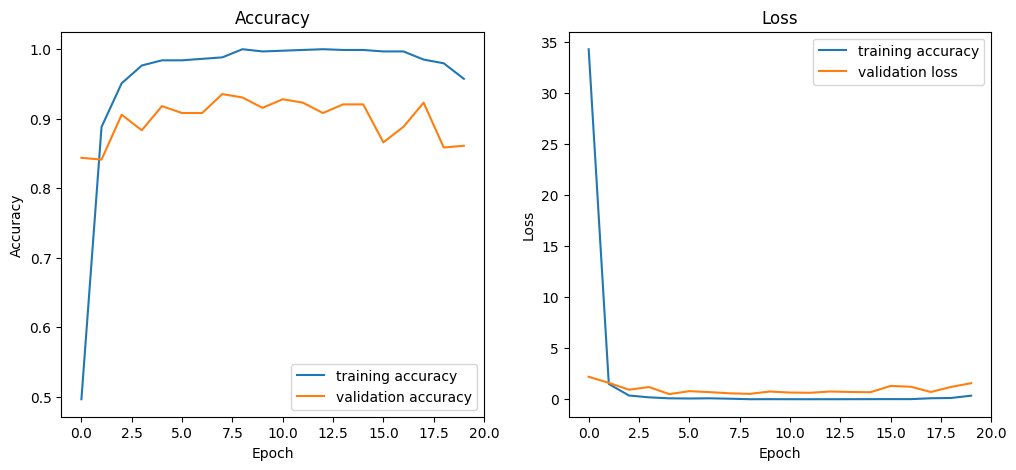

In [226]:
# accuracy plot
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axes[0].plot(hist['epoch'], hist['accuracy'], label='training accuracy')
axes[0].plot(hist['epoch'], hist['val_accuracy'], label='validation accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlim(-1, 20)
axes[0].legend()

axes[1].plot(hist['epoch'], hist['loss'], label='training accuracy')
axes[1].plot(hist['epoch'], hist['val_loss'], label='validation loss')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].set_xlim(-1, 20)
axes[1].legend()

plt.show()

In [227]:
# Retrieve the history of the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Retrieve the last entry in the training and validation accuracy lists
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")

Final Training Accuracy: 95.74%
Final Validation Accuracy: 86.10%


In [231]:
# load image to numpy array
from PIL import Image
img = Image.open("F:\Code Repos\CSCI316-Proj2\datasets\car_part\\test\\FUEL INJECTOR\\1.jpg")
img_arr = np.array(img)

In [232]:
# preprocess
preprocessed_image = preprocess_input(test_ds)
preprocessed_image.shape


(224, 224, 3)

In [234]:
prediction = model.predict(test_ds)

f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step


In [236]:
test_df

,class index,filepaths,labels,data set
233,1,datasets/car_part/train/ALTERNATOR/049.jpg,ALTERNATOR,train
3695,20,datasets/car_part/train/IGNITION COIL/159.jpg,IGNITION COIL,train
4943,28,datasets/car_part/train/OVERFLOW TANK/055.jpg,OVERFLOW TANK,train
1250,7,datasets/car_part/train/CARBERATOR/005.jpg,CARBERATOR,train
1424,7,datasets/car_part/train/CARBERATOR/179.jpg,CARBERATOR,train
...,...,...,...,...
186,1,datasets/car_part/train/ALTERNATOR/002.jpg,ALTERNATOR,train
2723,15,datasets/car_part/train/FUEL INJECTOR/084.jpg,FUEL INJECTOR,train
6586,37,datasets/car_part/train/SHIFT KNOB/161.jpg,SHIFT KNOB,train
327,1,datasets/car_part/train/ALTERNATOR/143.jpg,ALTERNATOR,train


In [235]:
prediction[0]

array([9.9999499e-01, 5.9929323e-07, 1.2919738e-15, 1.5020221e-10,
       6.0061774e-22, 1.1283511e-14, 4.4257536e-06, 1.9709848e-17,
       1.3392643e-08, 9.9416281e-11], dtype=float32)

In [241]:
np.argmax(prediction[0])

test_ds.class_indices

{'ALTERNATOR': 0,
 'CARBERATOR': 1,
 'ENGINE BLOCK': 2,
 'FUEL INJECTOR': 3,
 'IDLER ARM': 4,
 'IGNITION COIL': 5,
 'OVERFLOW TANK': 6,
 'RADIO': 7,
 'SHIFT KNOB': 8,
 'STARTER': 9}

In [242]:
model.save("models/top_10_model.h5")

## Attempt 3: Dropout Optimization & Class Increase

### Building Model

In [369]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [370]:
def build_model(hp, output_classes=50, dropout=0.2):
    base_model = InceptionV3(input_shape = (224, 224, 3), # image shape
                             include_top = False, # exclude the output layer of the model
                             weights='imagenet'
                            )
    
    base_model.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(
            hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)
        )(x)
    x = Dense(output_classes, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

### Generating Datasets

In [371]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [372]:
image_size = (224, 224)
batch_size=32

In [373]:
# reduce dataset to only include 100 samples from each class
undersampled_df = pd.DataFrame()

target_samples_per_class = 50

for class_label in df['labels'].unique():
    class_samples = df[df['labels'] == class_label]
    
    if len(class_samples) > target_samples_per_class:
        undersampled_class_df = resample(class_samples, replace=False, n_samples=target_samples_per_class, random_state=1)
    else:
        undersampled_class_df = class_samples
    
    undersampled_df = pd.concat([undersampled_df, undersampled_class_df])
    
print(f"Total Samples after undersampling: {len(undersampled_df)}")

Total Samples after undersampling: 2500


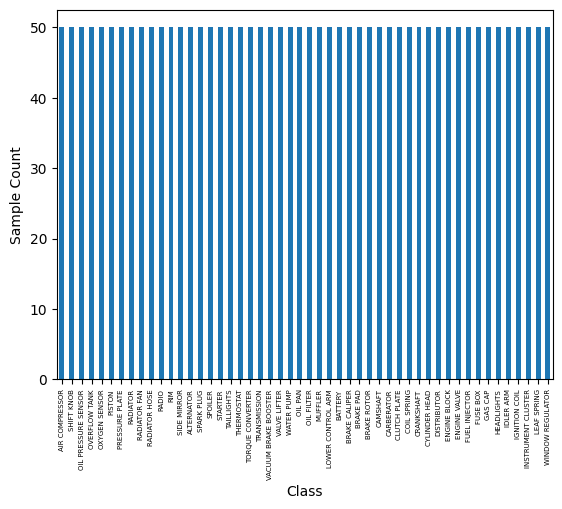

In [374]:
# look at class balance
undersampled_df['labels'].value_counts().plot(kind="bar")

plt.tick_params(axis='x', which='major', labelsize=5)
plt.xlabel("Class")
plt.ylabel("Sample Count")

plt.show()

In [375]:
# split undersampled data into 70/30 for train/test
train_df, test_df = train_test_split(
    undersampled_df, test_size=0.3, random_state=1
)
train_df

,class index,filepaths,labels,data set
4189,23,datasets/car_part/train/LOWER CONTROL ARM/163.jpg,LOWER CONTROL ARM,train
1343,7,datasets/car_part/train/CARBERATOR/098.jpg,CARBERATOR,train
544,2,datasets/car_part/train/BATTERY/170.jpg,BATTERY,train
6343,36,datasets/car_part/train/RIM/096.jpg,RIM,train
8003,45,datasets/car_part/train/TRANSMISSION/137.jpg,TRANSMISSION,train
...,...,...,...,...
3392,19,datasets/car_part/train/IDLER ARM/054.jpg,IDLER ARM,train
3199,18,datasets/car_part/train/HEADLIGHTS/020.jpg,HEADLIGHTS,train
3781,21,datasets/car_part/train/INSTRUMENT CLUSTER/045...,INSTRUMENT CLUSTER,train
816,4,datasets/car_part/train/BRAKE PAD/091.jpg,BRAKE PAD,train


In [376]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

# convert dataframes into datasets
train_ds = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1
)

test_ds = train_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1,
    shuffle=False
)

Found 1750 validated image filenames belonging to 50 classes.
Found 750 validated image filenames belonging to 50 classes.


### Training Model

In [377]:
from kerastuner.tuners import RandomSearch

In [378]:
tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hp_tuning',
    project_name='dropout_tuning'
)

In [379]:
tuner.search(train_ds,
             epochs=10)

Trial 4 Complete [00h 07m 51s]
accuracy: 0.9760000109672546

Best accuracy So Far: 0.9879999756813049
Total elapsed time: 00h 32m 36s


### Model Evaluation

In [380]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# This is the best dropout rate it found between the values [0.2, 0.4, 0.6]

best_hps.get('dropout_rate')

0.1

In [382]:
model = tuner.get_best_models()[0]

f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model.save("models/hp_dropout_model.h5")

#### Prediction

In [385]:
predictions = model.predict(test_ds)

f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 669ms/step


In [386]:
class_labels = {index: label for label, index in test_ds.class_indices.items()}

In [387]:
preds = []
pred_index = []
for pred in predictions:
    class_pred = np.argmax(pred)
    preds.append(class_labels[class_pred])
    pred_index.append(class_pred)
    
test_df['predicted_labels'] = preds
test_df['predicted_index'] = pred_index

test_df

,class index,filepaths,labels,data set,predicted_labels,predicted_index
4924,28,datasets/car_part/train/OVERFLOW TANK/036.jpg,OVERFLOW TANK,train,OVERFLOW TANK,28
947,5,datasets/car_part/train/BRAKE ROTOR/034.jpg,BRAKE ROTOR,train,WATER PUMP,48
4435,25,datasets/car_part/train/OIL FILTER/090.jpg,OIL FILTER,train,OIL FILTER,25
8332,47,datasets/car_part/train/VALVE LIFTER/124.jpg,VALVE LIFTER,train,VALVE LIFTER,47
1523,8,datasets/car_part/train/CLUTCH PLATE/086.jpg,CLUTCH PLATE,train,CLUTCH PLATE,8
...,...,...,...,...,...,...
7736,44,datasets/car_part/train/TORQUE CONVERTER/057.jpg,TORQUE CONVERTER,train,TORQUE CONVERTER,44
4498,25,datasets/car_part/train/OIL FILTER/153.jpg,OIL FILTER,train,OIL FILTER,25
4287,24,datasets/car_part/train/MUFFLER/092.jpg,MUFFLER,train,MUFFLER,24
2559,14,datasets/car_part/train/ENGINE VALVE/086.jpg,ENGINE VALVE,train,ENGINE VALVE,14


In [388]:
mismatch = test_df[test_df['labels'] != test_df['predicted_labels']]
mismatch

,class index,filepaths,labels,data set,predicted_labels,predicted_index
947,5,datasets/car_part/train/BRAKE ROTOR/034.jpg,BRAKE ROTOR,train,WATER PUMP,48
3088,17,datasets/car_part/train/GAS CAP/095.jpg,GAS CAP,train,DISTRIBUTOR,12
2191,12,datasets/car_part/train/DISTRIBUTOR/054.jpg,DISTRIBUTOR,train,RADIATOR HOSE,34
2680,15,datasets/car_part/train/FUEL INJECTOR/041.jpg,FUEL INJECTOR,train,DISTRIBUTOR,12
3174,17,datasets/car_part/train/GAS CAP/181.jpg,GAS CAP,train,COIL SPRING,9
...,...,...,...,...,...,...
6861,39,datasets/car_part/train/SPARK PLUG/060.jpg,SPARK PLUG,train,DISTRIBUTOR,12
4908,28,datasets/car_part/train/OVERFLOW TANK/020.jpg,OVERFLOW TANK,train,BRAKE CALIPER,3
4768,27,datasets/car_part/train/OIL PRESSURE SENSOR/06...,OIL PRESSURE SENSOR,train,DISTRIBUTOR,12
4255,24,datasets/car_part/train/MUFFLER/060.jpg,MUFFLER,train,OXYGEN SENSOR,29


In [407]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

##### Classification Report

In [409]:
rep = classification_report(
    y_true=test_df['labels'],
    y_pred=test_df['predicted_labels']
)

print(rep)

                      precision    recall  f1-score   support

      AIR COMPRESSOR       0.61      1.00      0.76        14
          ALTERNATOR       0.82      0.90      0.86        10
             BATTERY       1.00      0.87      0.93        15
       BRAKE CALIPER       0.64      0.64      0.64        11
           BRAKE PAD       1.00      0.78      0.88        18
         BRAKE ROTOR       0.83      0.83      0.83        12
            CAMSHAFT       0.83      0.71      0.77        14
          CARBERATOR       0.67      0.83      0.74        12
        CLUTCH PLATE       1.00      1.00      1.00        18
         COIL SPRING       0.86      1.00      0.92        12
          CRANKSHAFT       0.83      0.77      0.80        13
       CYLINDER HEAD       0.94      0.79      0.86        19
         DISTRIBUTOR       0.27      0.50      0.35        18
        ENGINE BLOCK       0.73      0.73      0.73        15
        ENGINE VALVE       0.94      0.94      0.94        16
       

In [412]:
with open("reports\\phase3b\\classification_report.txt", "w+") as file:
    file.write(rep)

##### Confusion Matrix 

In [395]:
cm = confusion_matrix(
    y_true=test_df['labels'],
    y_pred=test_df['predicted_labels'],
    labels=test_df['labels'].unique()
)

cm

array([[10,  0,  0, ...,  0,  0,  1],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0,  0, 15, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  8,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0,  9]], dtype=int64)

In [402]:
cm_df = pd.DataFrame(cm,
                     index=test_df['labels'].unique(),
                     columns=test_df['labels'].unique())

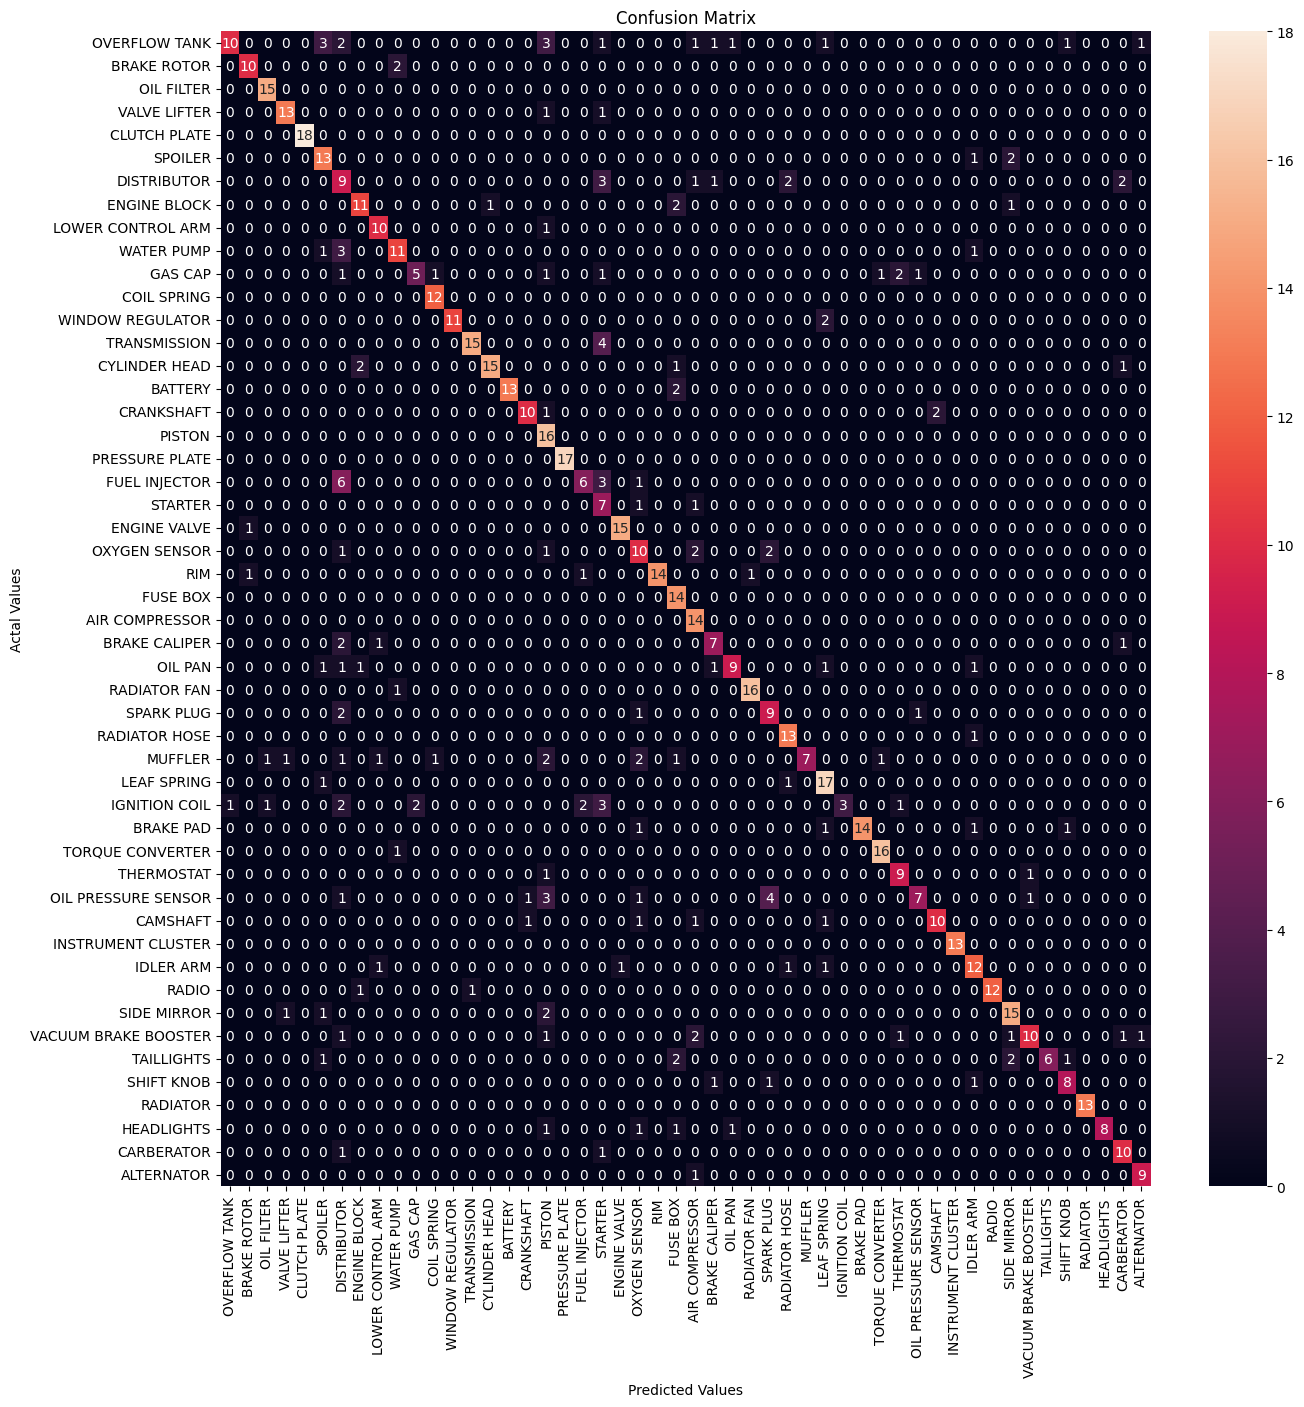

In [406]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()